In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import image_dataset_from_directory as IMFD
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import itertools

In [3]:
print(tf.__version__)

2.18.0


In [ ]:
import os

# Global Variables
DATASET_PATH = "/content/drive/MyDrive/TasteTrip/testing/dataset_padang_food"

SPLIT_DATASET_PATH = "/content/drive/MyDrive/TasteTrip/testing/split_dataset"
TRAIN_PATH = os.path.join(SPLIT_DATASET_PATH, 'train')
VAL_PATH = os.path.join(SPLIT_DATASET_PATH, 'val')

FOOD_LIST = os.listdir(DATASET_PATH)
NUM_OF_FOOD = len(FOOD_LIST)

print('Food total:', NUM_OF_FOOD)

Food total: 9


In [ ]:
# Constants
LABEL_MODE = 'categorical'
COLOR_MODE = 'rgb'
BATCH_SIZE = 32
IMAGE_SIZE = (384, 384)
SEED = 314

# Create train dataset
train_dataset = IMFD(
    TRAIN_PATH,
    label_mode=LABEL_MODE,
    color_mode=COLOR_MODE,
    batch_size=BATCH_SIZE,
    image_size=IMAGE_SIZE,
    seed=SEED,
)

# Create validation dataset
val_dataset = IMFD(
    VAL_PATH,
    label_mode=LABEL_MODE,
    color_mode=COLOR_MODE,
    batch_size=BATCH_SIZE,
    image_size=IMAGE_SIZE,
    seed=SEED,
)

# Get class names
food_names = train_dataset.class_names
print('\nClass Names:\n{}'.format(food_names))

Found 695 files belonging to 9 classes.
Found 298 files belonging to 9 classes.

Class Names:
['ayam_goreng', 'ayam_pop', 'daging_rendang', 'dendeng_batokok', 'gulai_ikan', 'gulai_tambusu', 'gulai_tunjang', 'telur_balado', 'telur_dadar']


In [ ]:
# Check Shape per batch
for images, labels in train_dataset.take(1):  # Iterate through the first batch in the training dataset
    print('Batch Image Shape:', images.shape)
    print('Batch Labels Shape:', labels.shape)
    break

Batch Image Shape: (32, 384, 384, 3)
Batch Labels Shape: (32, 9)


In [ ]:
# Preprocess data: rescaling and augmentation

rescale_layer = tf.keras.Sequential([
    tf.keras.layers.Rescaling(1./255)
])

augmentation_layer = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(
        (-0.2, 0.2),
        fill_mode='reflect',
        interpolation='bilinear'
    ),
    tf.keras.layers.RandomTranslation(
        (-0.15, 0.15),
        (-0.15, 0.15),
        fill_mode='reflect',
        interpolation='bilinear'
    ),
])

def preprocess_dataset(dataset, augment=False):
    # Rescale all datasets
    dataset = dataset.map(lambda x, y: (rescale_layer(x), y))

    # Data augmentation only on the training set.
    if augment:
        dataset = dataset.map(lambda x, y: (augmentation_layer(x, training=True), y))

    return dataset

train_ds = preprocess_dataset(train_dataset, augment=True)
val_ds = preprocess_dataset(val_dataset)

In [ ]:
from tensorflow.keras import layers

# Base Model
input_shape = (384, 384, 3)
base_model = tf.keras.applications.efficientnet_v2.EfficientNetV2S(
    include_top=False,
    weights='imagenet',
    input_shape=input_shape,
    include_preprocessing=False
)
base_model.trainable = False

# Functional API for Keras Model Building
inputs = tf.keras.Input(shape=input_shape)
x = base_model(inputs, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(640, activation='relu')(x)
x = layers.Dropout(0.6)(x)
x = layers.Dense(320, activation='relu')(x)
x = layers.Dropout(0.2)(x)
outputs = layers.Dense(NUM_OF_FOOD, activation='softmax')(x)

# Create the final model using Functional API
model = tf.keras.Model(inputs, outputs)

# Display the summary of the final model
model.summary()

82420632/82420632 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 384, 384, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ efficientnetv2-s (Functional)        │ (None, 12, 12, 1280)        │      20,331,360 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 640)                 │         819,840 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 640)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 320)                 │         205,120 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 320)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 9)                   │           2,889 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 21,359,209 (81.48 MB)

 Trainable params: 1,027,849 (3.92 MB)

 Non-trainable params: 20,331,360 (77.56 MB)

In [ ]:
learning_rate = 1e-4
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

model.compile(optimizer=optimizer,
                    loss='categorical_crossentropy',
                    metrics=['accuracy'])

In [ ]:
# prompt: create a tensorflow model training callback for condition stopping on epoch end (train accuracy > 94% and val accuracy > 90%), plus model checkpoint save

class myCallback(tf.keras.callbacks.Callback):
    def __init__(self, checkpoint_filepath):
        super(myCallback, self).__init__()
        self.checkpoint_filepath = checkpoint_filepath

    def on_epoch_end(self, epoch, logs={}):
        if (logs.get('accuracy') > 0.94 and logs.get('val_accuracy') > 0.92):
            print("\nReached desired accuracy, stopping training!")
            self.model.stop_training = True
        # Save model checkpoint based on validation accuracy
        self.model.save(self.checkpoint_filepath)

# Update with your desired path
checkpoint_filepath = '/content/drive/MyDrive/TasteTrip/testing/best_model.keras'

callbacks = [
    myCallback(checkpoint_filepath),
    tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_filepath,
                                        save_weights_only=False,
                                        monitor='val_accuracy',
                                        mode='max',
                                        save_best_only=True)
]

In [ ]:
EPOCHS = 100

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    verbose=1,
    callbacks=callbacks
)

Epoch 1/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 245s 9s/step - accuracy: 0.1301 - loss: 2.2472 - val_accuracy: 0.5067 - val_loss: 1.9310
Epoch 2/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 36s 2s/step - accuracy: 0.3252 - loss: 1.9596 - val_accuracy: 0.6611 - val_loss: 1.6725
Epoch 3/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 35s 2s/step - accuracy: 0.4939 - loss: 1.6990 - val_accuracy: 0.6812 - val_loss: 1.3988
Epoch 4/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 40s 2s/step - accuracy: 0.5797 - loss: 1.4512 - val_accuracy: 0.7248 - val_loss: 1.1536
Epoch 5/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 38s 2s/step - accuracy: 0.6567 - loss: 1.2146 - val_accuracy: 0.7617 - val_loss: 0.9377
Epoch 6/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 35s 2s/step - accuracy: 0.7248 - loss: 1.0150 - val_accuracy: 0.7886 - val_loss: 0.7846
Epoch 7/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 34s 2s/step - accuracy: 0.7101 - loss: 0.9711 - val_accuracy: 0.8289 - val_loss: 0.6727
Epoch 8/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 39s 1s/step - accuracy: 0.7196 - loss: 0.8370 - val_accuracy: 0.8154 - 

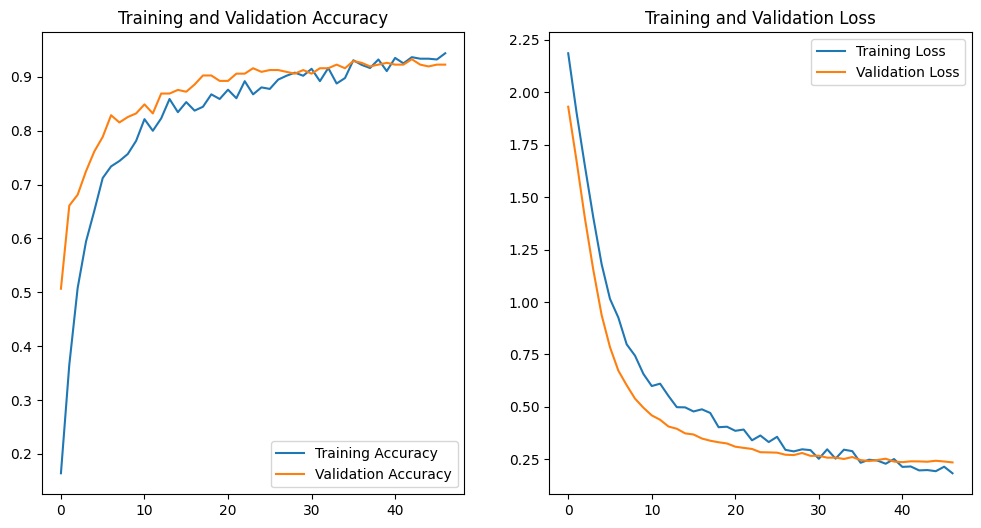

In [ ]:
# prompt: create a plot for model history with accuracy and epoch, create a comparison for both training set and validation set

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(acc))

# Accuracy
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

# Loss
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.show()

In [1]:
!pip install tensorflowjs

INFO: pip is looking at multiple versions of tf-keras to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.1/89.1 kB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.9/15.9 MB 84.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 615.3/615.3 MB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 54.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 97.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.3/9.3 MB 96.6 MB/s eta 0:00:00
  Attempting uninstall: packaging
    Found existing installation: packaging 24.2
    Uninstalling packaging-24.2:
      Successfully uninstalled packaging-24.2
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.17.1
    Uninstalling tensorboard-2.17.1:
      Successfully unin

In [5]:
new_model = tf.keras.models.load_model('/content/drive/MyDrive/TasteTrip/Experimental/best_model.keras')

In [6]:
new_model.export('/content/drive/MyDrive/TasteTrip/Experimental/saved_model')

Saved artifact at '/content/drive/MyDrive/TasteTrip/Experimental/saved_model'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 384, 384, 3), dtype=tf.float32, name='input_layer_1')
Output Type:
  TensorSpec(shape=(None, 9), dtype=tf.float32, name=None)
Captures:
  134678188418048: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134678188638800: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134678188640912: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134678188421040: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134678188423328: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134678188647424: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134678188647072: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134678188649888: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134678188644784: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134678188649008: TensorSpec(shape=(), dtyp

In [7]:
!tensorflowjs_converter --input_format=tf_saved_model \
    /content/drive/MyDrive/TasteTrip/Experimental/saved_model \
    /content/drive/MyDrive/TasteTrip/Experimental/tfjs_model

2024-11-25 08:14:48.704192: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1732522488.751004    3517 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1732522488.765094    3517 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
🌲 Try https://ydf.readthedocs.io, the successor of TensorFlow Decision Forests with more features and faster training!
2024-11-25 08:14:52.952978: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)
I0000 00:00:1732522499.627032    3517 devices.cc:67] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 0
I0000 00:00